In [1256]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
ticker = 'FEDERALBNK.NS'
stock = yf.download(ticker, start="2020-07-01", end="2024-01-01")
window = 30  # Lookback period for Bollinger Bands (2 months)
num_std_dev = 2  # Standard deviation multiplier

# Calculate Bollinger Bands
stock['Middle Band'] = stock['Close'].rolling(window).mean()
stock['Std Dev'] = stock['Close'].rolling(window).std()
stock['Upper Band'] = stock['Middle Band'] + (num_std_dev * stock['Std Dev'])
stock['Lower Band'] = stock['Middle Band'] - (num_std_dev * stock['Std Dev'])

filtered_stock = stock.loc["2021-01-01":].copy()


[*********************100%***********************]  1 of 1 completed


In [1258]:

# Flatten multi-index columns
filtered_stock.columns = [col[0] for col in filtered_stock.columns]



In [1260]:
# Generate Buy/Sell signals correctly
filtered_stock['Buy Signal'] = (filtered_stock['Close'] < filtered_stock['Lower Band']).astype(int)
filtered_stock['Sell Signal'] = (filtered_stock['Close'] > filtered_stock['Upper Band']).astype(int) * -1

#print(filtered_stock.head())

In [1262]:
# Initialize trade position
position = None  

# Iterate through rows
for index, row in filtered_stock.iterrows():
    if position is None and row['Buy Signal'] == 1:  # Buy when first buy signal appears
        position = "Bought"
        filtered_stock.at[index, 'Trade'] = 1  # Execute Buy trade
        
    elif position == "Bought" and row['Sell Signal'] == -1:  # Sell at first sell signal after buying
        position = None  # Exit trade
        filtered_stock.at[index, 'Trade'] = -1  # Execute Sell trade

filtered_stock.to_csv("trade_data.csv", index=True)

#print(filtered_stock.head())

In [1287]:
# Initial capital
initial_cash = 10000  # Starting cash balance in INR
cash_balance = initial_cash  # Start with all cash
shares_held = 0  # No stocks held at start

# Track portfolio value over time
filtered_stock['Portfolio Value'] = float(initial_cash)  

# Backtesting: Sequential trade execution
for index, row in filtered_stock.iterrows():
    if row['Trade'] == 1 and cash_balance >= row['Close']:  # Buy signal & enough cash
        shares_held = int(cash_balance // row['Close'])  # Buy max whole shares
        cash_balance -= shares_held * row['Close']  # Deduct cost
        
    elif row['Trade'] == -1 and shares_held > 0:  # Sell signal & shares exist
        cash_balance += shares_held * row['Close']  # Convert shares to cash
        shares_held = 0  # Reset holdings

    filtered_stock.at[index, 'Portfolio Value'] = float(shares_held * row['Close'] + cash_balance)  # Track value

        
# Ensure final sell if still holding stocks at end
if shares_held > 0:
    cash_balance += shares_held * filtered_stock.iloc[-1]['Close']  # Sell at last price
    shares_held = 0  # Reset holdings
    filtered_stock.at[filtered_stock.index[-1], 'Trade'] = -1  # Mark forced exit

# Final portfolio value calculation
final_value = cash_balance  

# Display results
print(f"Initial Portfolio Value: ₹{initial_cash}")
print(f"Final Portfolio Value: ₹{final_value}")
margins = (final_value - initial_cash) / initial_cash * 100
print(f"Total Return: {margins:.2f}%")
#filtered_stock.to_csv("trade_backtest_results.csv", index=True)


Initial Portfolio Value: ₹10000
Final Portfolio Value: ₹17856.26961517334
Total Return: 78.56%


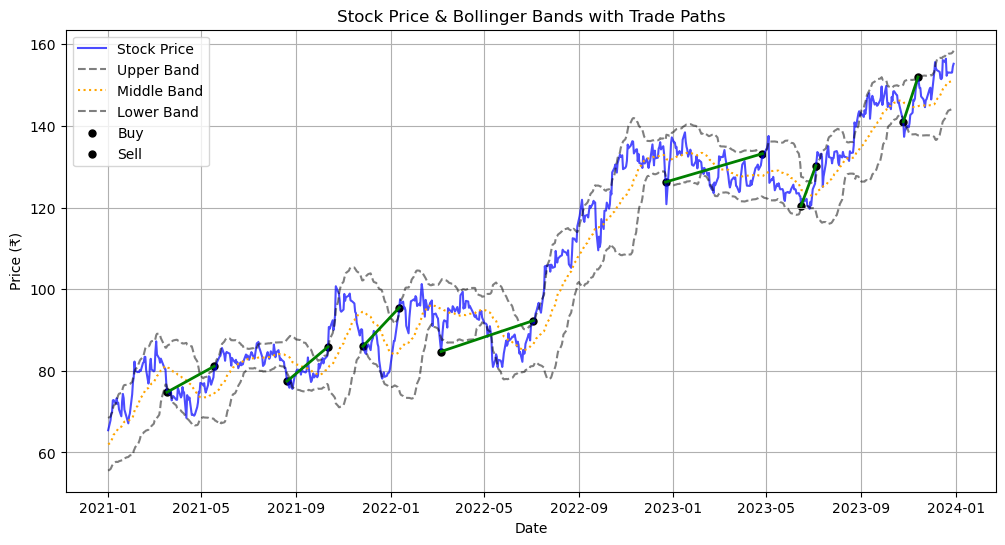

In [1285]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot Stock Price
plt.plot(filtered_stock.index, filtered_stock['Close'], label="Stock Price", color='blue', alpha=0.7,linewidth=1.5)

# Plot Bollinger Bands
plt.plot(filtered_stock.index, filtered_stock['Upper Band'], label="Upper Band", color='black', linestyle="dashed", alpha=0.5)
plt.plot(filtered_stock.index, filtered_stock['Middle Band'], label="Middle Band", color='orange', linestyle="dotted")
plt.plot(filtered_stock.index, filtered_stock['Lower Band'], label="Lower Band", color='black', linestyle="dashed", alpha=0.5)

# Draw lines connecting Buy to Sell trades based on profit/loss
for buy_idx, buy_row in buy_signals.iterrows():
    # Find the next Sell signal after this Buy
    sell_after_buy = sell_signals[sell_signals.index > buy_idx].first_valid_index()
    
    if sell_after_buy:
        sell_price = filtered_stock.loc[sell_after_buy, 'Close']
        buy_price = buy_row['Close']

        # Determine color based on profit/loss
        line_color = 'green' if sell_price > buy_price else 'red'

        # Draw line from Buy to corresponding Sell
        plt.plot([buy_idx, sell_after_buy], [buy_price, sell_price], color=line_color, linewidth=2)
    else: print('blah')        
# Highlight Buy & Sell Signals
buy_signals = filtered_stock[filtered_stock['Trade'] == 1]
sell_signals = filtered_stock[filtered_stock['Trade'] == -1]

plt.scatter(buy_signals.index, buy_signals['Close'], marker='.', color='black', label='Buy', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='.', color='black', label='Sell', s=100)


plt.title("Stock Price & Bollinger Bands with Trade Paths")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)

plt.show()

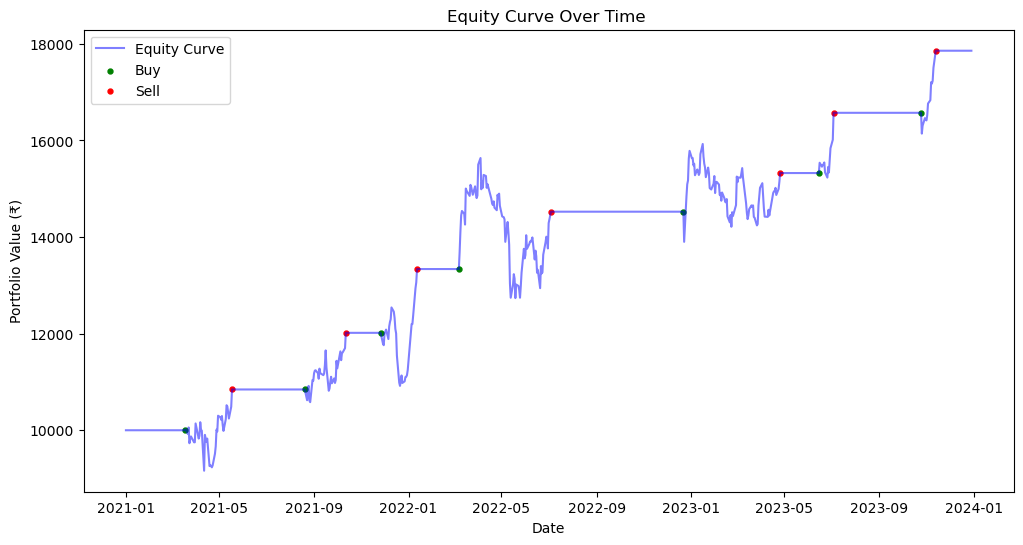

In [1268]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot Equity Curve
plt.plot(filtered_stock.index, filtered_stock['Portfolio Value'], label="Equity Curve", color='blue', linewidth=1.5, alpha=0.5)

# Highlight Buy & Sell points
plt.scatter(filtered_stock.index[filtered_stock['Trade'] == 1], filtered_stock['Portfolio Value'][filtered_stock['Trade'] == 1], marker='.', color='green', label='Buy', s=50)
plt.scatter(filtered_stock.index[filtered_stock['Trade'] == -1], filtered_stock['Portfolio Value'][filtered_stock['Trade'] == -1], marker='.', color='red', label='Sell', s=50)

# Formatting
plt.title("Equity Curve Over Time ")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.legend()
plt.grid(False)

# Show Plot
plt.show()

In [1270]:
risk_free_rate = 0.05  # Assume 5% annual risk-free rate (adjust based on market)
daily_returns = filtered_stock['Portfolio Value'].pct_change().dropna()

sharpe_ratio = (daily_returns.mean() - (risk_free_rate / 252)) / daily_returns.std() * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 0.85


In [1272]:
downside_returns = daily_returns[daily_returns < 0]  # Focus on negative returns
sortino_ratio = (daily_returns.mean() - (risk_free_rate / 252)) / downside_returns.std() * np.sqrt(252)
print(f"Sortino Ratio: {sortino_ratio:.2f}")

Sortino Ratio: 0.80


In [1274]:
rolling_max = filtered_stock['Portfolio Value'].cummax()
drawdown = filtered_stock['Portfolio Value'] / rolling_max - 1
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Maximum Drawdown: -18.54%


In [1276]:
winning_trades = filtered_stock[(filtered_stock['Trade'] == -1) & (filtered_stock['Close'] > filtered_stock.shift(1)['Close'])].shape[0]
total_trades = filtered_stock[filtered_stock['Trade'] == -1].shape[0]

win_rate = winning_trades / total_trades if total_trades > 0 else 0
print(f"Win Rate: {win_rate:.2%}")

Win Rate: 100.00%


In [1278]:
profits = (filtered_stock[(filtered_stock['Trade'] == -1) & (filtered_stock['Close'] > filtered_stock.shift(1)['Close'])]['Close'] - filtered_stock.shift(1)['Close']).sum()
losses = (filtered_stock[(filtered_stock['Trade'] == -1) & (filtered_stock['Close'] < filtered_stock.shift(1)['Close'])]['Close'] - filtered_stock.shift(1)['Close']).sum()

profit_factor = abs(profits / losses) if losses != 0 else float('inf')  # Avoid division by zero
print(f"Profit Factor: {profit_factor:.2f}")

Profit Factor: inf


In [1280]:
nifty = yf.download("^NSEI", start="2021-01-01", end="2024-01-01")  # Nifty 50 data
nifty_cumulative_return = (nifty['Close'].iloc[-1] / nifty['Close'].iloc[0]) - 1
nifty_cumulative_return = float(nifty_cumulative_return.iloc[0])

print(f"Strategy Cumulative Return: {margins:.2f}%")
print(f"Nifty Cumulative Return: {nifty_cumulative_return:.2%}")

if margins > nifty_cumulative_return*100 :
    print(f"{ticker} outperformed the market")
else : print(f"{ticker} underperformed compared to the market")

[*********************100%***********************]  1 of 1 completed

Strategy Cumulative Return: 78.56%
Nifty Cumulative Return: 55.02%
FEDERALBNK.NS outperformed the market


In [1282]:
# Create DataFrame for results
results = pd.DataFrame({
    'Metric': [
        'Cumulative Return', 'Annualized Return', 'Sharpe Ratio',
        'Sortino Ratio', 'Max Drawdown', 'Win Rate', 'Profit Factor'
    ],
    'Value': [
        f"{margins:.2f}%", f"{annualized_return:.2%}", f"{sharpe_ratio:.2f}",
        f"{sortino_ratio:.2f}", f"{max_drawdown:.2%}", f"{win_rate:.2%}", f"{profit_factor:.2f}"
    ]
})

# Apply formatting
styled_results = results.style.set_properties(**{
    'background-color': '#f7f7f7',
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#333'), ('color', 'white'), ('font-weight', 'bold')]}
]).set_caption("📊 Trading Performance Summary")

styled_results

,Metric,Value
0,Cumulative Return,78.56%
1,Annualized Return,21.15%
2,Sharpe Ratio,0.85
3,Sortino Ratio,0.80
4,Max Drawdown,-18.54%
5,Win Rate,100.00%
6,Profit Factor,inf
